In [1]:
import os
import gc
import time
import pickle
import numpy as np; np.random.seed(42)
import pandas as pd
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, compute_weights, reduce_mem_usage
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
logger = open(f"../logs/pipeline-level12-{datetime.now()}", "w")

***
# Input data

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
weighting_input = pd.read_parquet("../input/weighting_input.parquet")

In [4]:
infile = open("../input/encoders.pkl", "rb")
encoders = pickle.load(infile)
infile.close()
encoders["store"]

OrdinalEncoder(cols=['store_id'], drop_invariant=False, handle_missing='value',
               handle_unknown='value',
               mapping=[{'col': 'store_id', 'data_type': dtype('O'),
                         'mapping': CA_1     1
CA_2     2
CA_3     3
CA_4     4
TX_1     5
TX_2     6
TX_3     7
WI_1     8
WI_2     9
WI_3    10
NaN     -2
dtype: int64}],
               return_df=True, verbose=0)

In [5]:
STORE_ID = 3 # CA_3
data = data.query("store_id == @STORE_ID").reset_index(drop=True)
data.drop(["snap_TX", "snap_WI", "snap_TX_cum", "snap_WI_cum"], axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750602 entries, 0 to 4750601
Data columns (total 39 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ts_id              int16         
 1   item_id            int16         
 2   dept_id            int8          
 3   cat_id             int8          
 4   store_id           int8          
 5   state_id           int8          
 6   y                  int16         
 7   ds                 datetime64[ns]
 8   snap_CA            int8          
 9   snap_CA_cum        int8          
 10  event_name_1       int8          
 11  event_type_1       int8          
 12  event_name_2       int8          
 13  event_type_2       int8          
 14  sell_price         float32       
 15  n_prices           float32       
 16  regular_price      float32       
 17  price_iqr1         float32       
 18  price_iqr2         float32       
 19  price_min          float32       
 20  price_max          float

In [7]:
logger.write(f"\n- only store_id: {STORE_ID} \n\n")
logger.flush()

***
# Models configuration

In [8]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':200,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**9-1,
    'min_data_in_leaf': 2**9-1,
    'learning_rate': 0.03, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    #'feature_fraction_bynode':0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "store_id",
    "state_id",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "prev_newyear",
    "post_newyear",
    "no_stock_days",
    "discount",
    #"price_momentum_q",
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    #"lags": list(range(1,15)),
    "window_shifts":[1,7,28,56],
    "window_functions":["mean","median","std","kurt",],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{"item_id":"default", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "event_name_1":"default",
    },
    "ts_uid_columns":["item_id",]
}

lagged_features = list()
if "lags" in model_kwargs.keys():
    lag_features = [f"lag{lag}" for lag in model_kwargs["lags"]]
    lagged_features.extend(lag_features)
if "window_functions" in model_kwargs.keys():
    rw_features = [f"{window_func}{window_size}_shift{window_shift}" 
                   for window_func in model_kwargs["window_functions"]
                   for window_size in model_kwargs["window_sizes"]
                   for window_shift in model_kwargs["window_shifts"]]
    lagged_features.extend(rw_features)
    
lagged_features_to_dropna = [feat for feat in lagged_features if feat not in ["skew", "kurt"]]

In [9]:
logger.write("#"*100+"\n")
logger.write(" MODEL CONFIGURATION ".center(100, "#")+"\n")
logger.write("#"*100+"\n\n")
logger.write(f"- model_params: \n{model_params}\n\n")
logger.write(f"- time_features: \n{model_kwargs['time_features']}\n\n")
if "lags" in model_kwargs.keys():
    logger.write(f"- lags: \n{model_kwargs['lags']}\n\n")
if "window_functions" in model_kwargs.keys():
    logger.write(f"- window_functions: \n{model_kwargs['window_functions']}\n\n")
if "window_shifts" in model_kwargs.keys():
    logger.write(f"- window_shifts: \n{model_kwargs['window_shifts']}\n\n")
if "window_sizes" in model_kwargs.keys():
    logger.write(f"- window_sizes: \n{model_kwargs['window_sizes']}\n\n")
logger.write(f"- categorical_features: \n{model_kwargs['categorical_features']}\n\n")
logger.flush()

***

In [10]:
valid_periods = [
    (pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
    (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
    (pd.to_datetime("2016-03-28"), pd.to_datetime("2016-04-24")),
    (pd.to_datetime("2016-04-25"), pd.to_datetime("2016-05-22")),
]

####################################################################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################


../lib/utils.py:57: RuntimeWarning:

Mean of empty slice



Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8489
[LightGBM] [Info] Number of data points in the train set: 2157843, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.940685
[50]	valid_0's wrmsseL12: 0.793369
[75]	valid_0's wrmsseL12: 0.745942
[100]	valid_0's wrmsseL12: 0.732828
[125]	valid_0's wrmsseL12: 0.72935
[150]	valid_0's wrmsseL12: 0.728099
[175]	valid_0's wrmsseL12: 0.72705
[200]	valid_0's wrmsseL12: 0.726726
[225]	valid_0's wrmsseL12: 0.726582
[250]	valid_0's wrmsseL12: 0.726532
[275]	valid_0's wrmsseL12: 0.726385
[300]	valid_0's wrmsseL12: 0.726421
[325]	valid_0's wrmsseL12: 0.726494
[350]	valid_0's wrmsseL12: 0.726869
[375]	valid_0's wrmsseL12: 0.72668
[400]	valid_0's wrmsseL12: 0

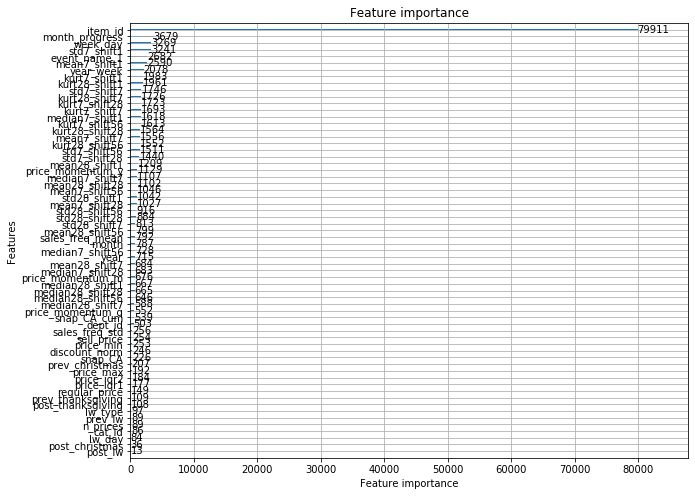

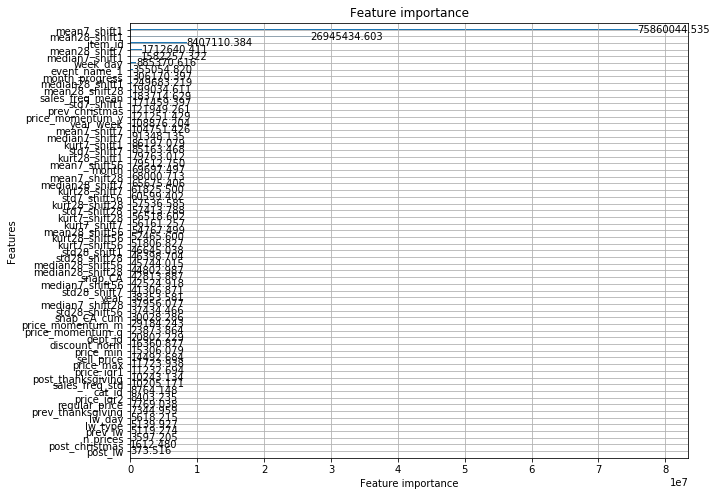

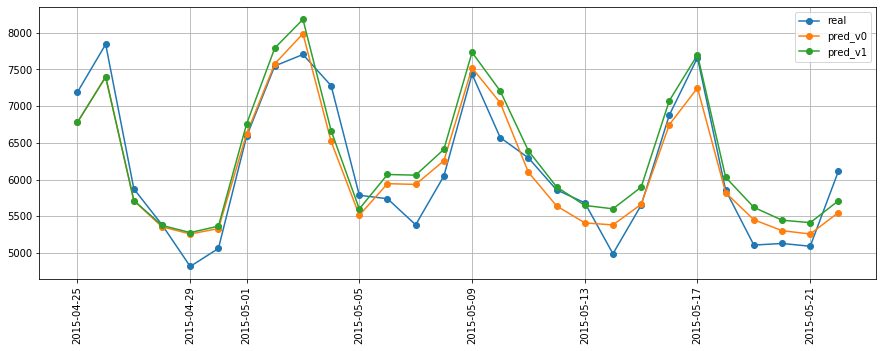

####################################################################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8508
[LightGBM] [Info] Number of data points in the train set: 2215618, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.963916
[50]	valid_0's wrmsseL12: 0.817955
[75]	valid_0's wrmsseL12: 0.7725
[100]	valid_0's wrmsseL12: 0.760248
[125]	valid_0's wrmsseL12: 0.756803
[150]	valid_0's wrmsseL12: 0.755099
[175]	valid_0's wrmsseL12: 0.75387
[200]	valid_0

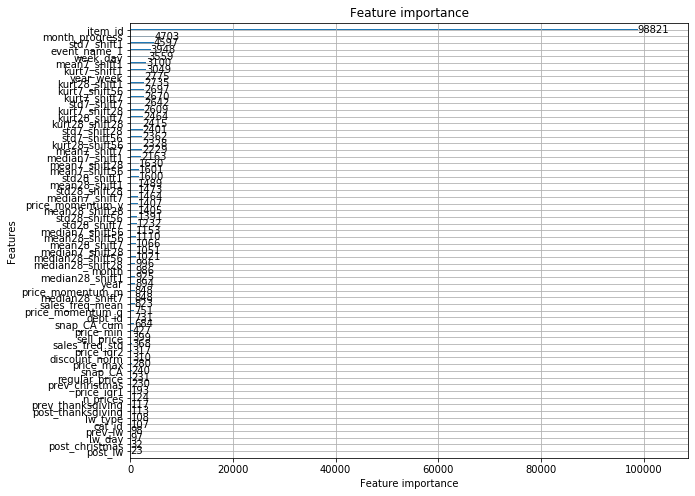

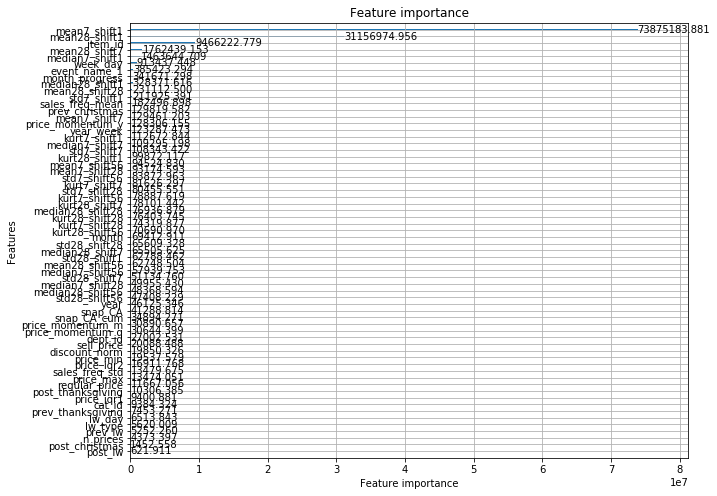

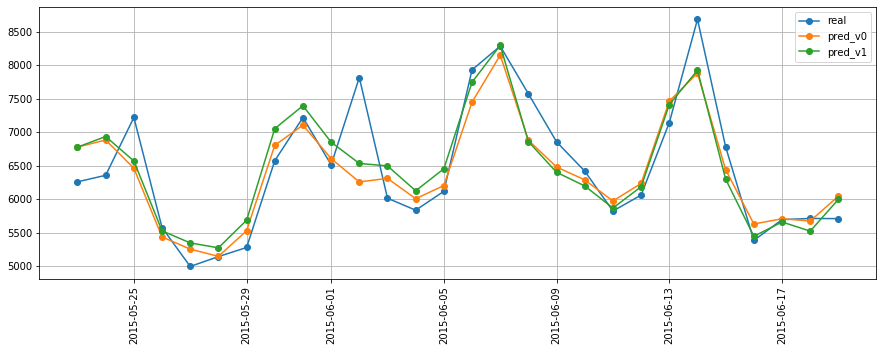

####################################################################################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8649
[LightGBM] [Info] Number of data points in the train set: 2856354, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.966965
[50]	valid_0's wrmsseL12: 0.826152
[75]	valid_0's wrmsseL12: 0.783576
[100]	valid_0's wrmsseL12: 0.772879
[125]	valid_0's wrmsseL12: 0.770663
[150]	valid_0's wrmsseL12: 0.769928
[175]	valid_0's wrmsseL12: 0.769687
[200]	vali

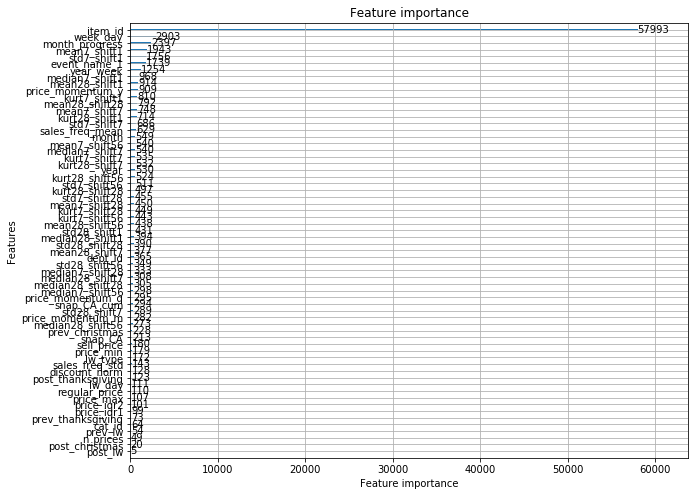

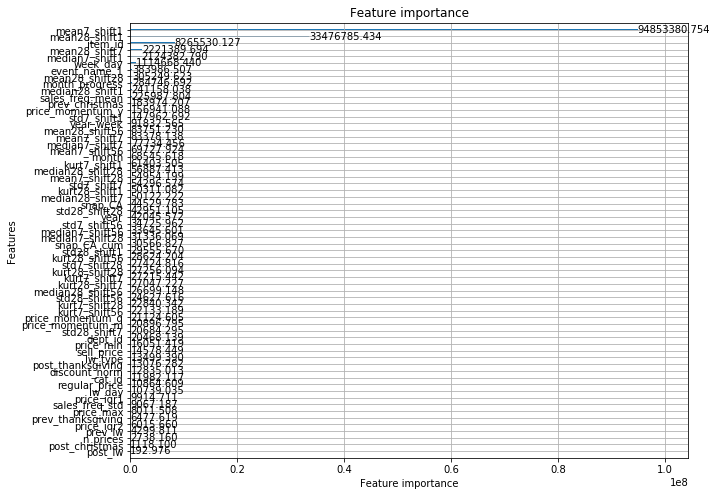

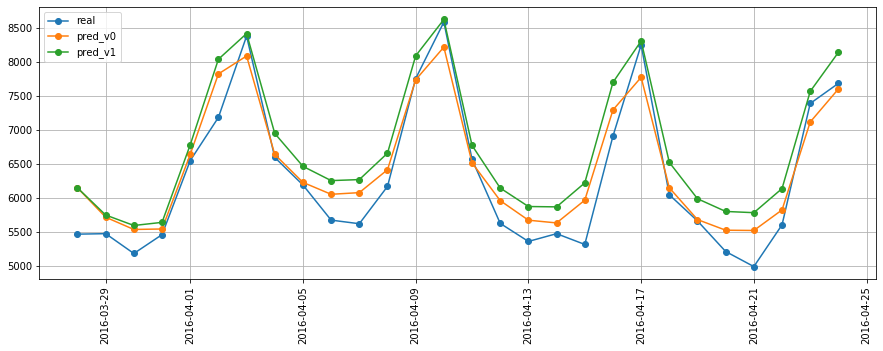

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.213034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8653
[LightGBM] [Info] Number of data points in the train set: 2916486, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.929955
[50]	valid_0's wrmsseL12: 0.789402
[75]	valid_0's wrmsseL12: 0.747613
[100]	valid_0's wrmsseL12: 0.738538
[125]	valid_0's wrmsseL12: 0.736594
[150]	valid_0's wrmsseL12: 0.736005
[175]	valid_0's wrmsseL12: 0.736126
[200]	vali

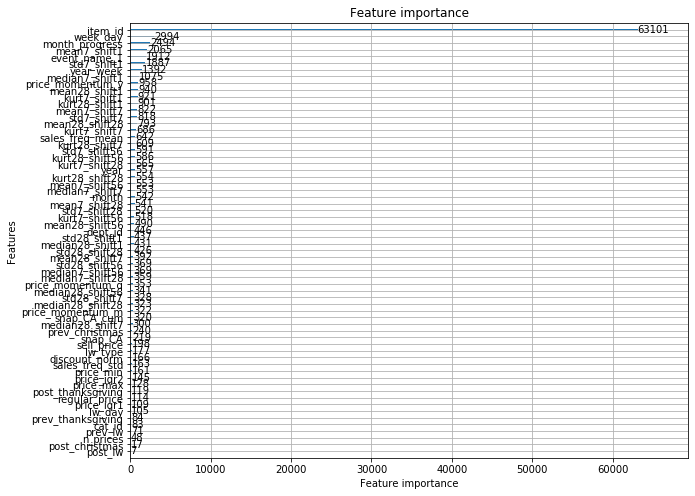

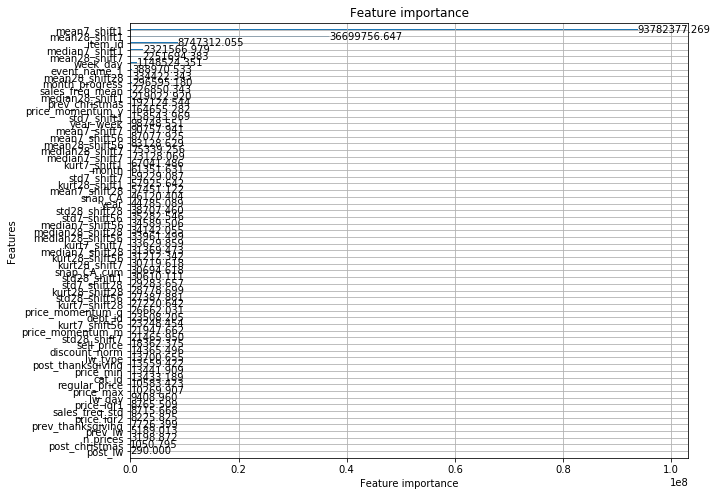

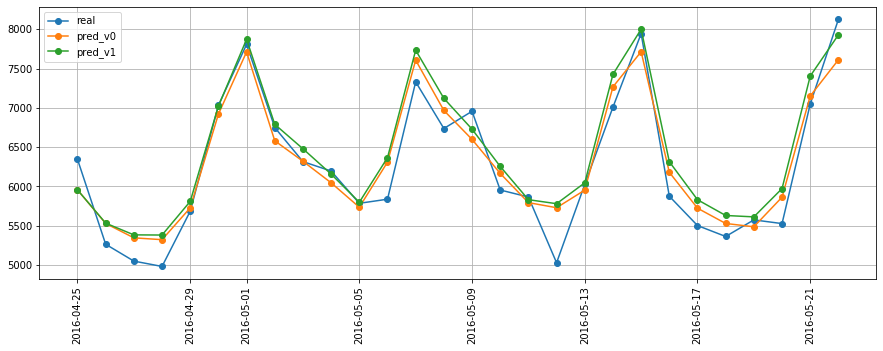

CPU times: user 3h 44min 26s, sys: 40min 6s, total: 4h 24min 33s
Wall time: 36min 46s


In [11]:
%%time
errors_v0 = dict()
errors_v1 = dict()

for i,valid_period in enumerate(valid_periods):

    print("#"*100)
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    logger.write("#"*100 + "\n")
    logger.write(f" Validation period: {valid_period} ".center(100, "#") + "\n")
    logger.write("#"*100 + "\n\n")

    valid_start = valid_period[0]
    valid_end = valid_period[1]
    _train_data = data.query("ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    scales_level12 = compute_scaling(scaling_input, 
                                     cut_date=valid_start,
                                     agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)
    weights_level12 = compute_weights(weighting_input, 
                                      start_date=valid_start, level=12)
    
    model_level12 = LightGBMForecaster(**model_kwargs)
    model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index)
    model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
    #drop_idx = model_level12.train_features.query("no_stock_days >= 7*sales_freq_mean").index
    #model_level12.train_features.drop(drop_idx, inplace=True)
    model_level12.train_features = reduce_mem_usage(model_level12.train_features)
    model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
    
    ts_id_in_train = model_level12.train_features.ts_id.unique()
    model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")

    logger.write(f"- training samples: {len(model_level12.train_features)} \n\n")
    logger.write(f"- validation samples: {len(model_level12.valid_features)} \n\n")
    logger.write(f"- ts in train set: {model_level12.train_features.ts_id.nunique()} \n\n")
    logger.write(f"- ts in valid set: {model_level12.valid_features.ts_id.nunique()} \n\n")
    logger.write(f"- input_features: {model_level12.input_features} \n\n")
    logger.flush()
    
    print("Fitting the model")
    tic = time.time()
    evaluator = WRMSSEEvaluatorL12(model_level12.valid_features, weights_level12, scales_level12)
    model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")
    
    logger.write(f"- best_iteration: {model_level12.best_iteration} \n\n")
    logger.flush()

    lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
    lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))
    
    valid_dataframe = (model_level12.valid_features
                       .loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]]
                       .copy())
    evaluator = WRMSSEEvaluatorL12(valid_dataframe, weights_level12, scales_level12)

    print("Predicting with ground thruth lagged values")
    tic = time.time()
    forecast_v0 = (model_level12.valid_features
                   .loc[:, ["ds"]+model_level12.ts_uid_columns]
                   .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")

    wrmsse = evaluator._evaluate(forecast_v0.y_pred.values)
    errors_v0[f"f{i}"] = wrmsse
    print("wrmsse:", wrmsse)
    
    logger.write(f"- wrmsse approach 1: {wrmsse} \n\n")
    logger.flush()

    print("Predicting with recursive approach")
    tic = time.time()
    valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
    forecast_v1 = model_level12.predict(valid_data, recursive=True)
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")
    
    wrmsse = evaluator._evaluate(forecast_v1.y_pred.values)
    errors_v1[f"f{i}"] = wrmsse
    print("wrmsse:", wrmsse)
    
    logger.write(f"- wrmsse approach 2: {wrmsse} \n\n")
    logger.flush()
    
    mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
           .merge(forecast_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
           .merge(forecast_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
    plt.figure(figsize=(15,5))
    plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
    plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
    plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()
    
    del model_level12, _train_data, _valid_index
    gc.collect()

***

In [14]:
approach1 = list(errors_v0.values())
approach2 = list(errors_v1.values())

logger.write("#"*100 + "\n")
logger.write(f" Overall ".center(100, "#") + "\n")
logger.write("#"*100 + "\n\n")

logger.write(f"- approach 1 on all folds: {approach1} - mean: {np.mean(approach1)} \n\n")
logger.write(f"- approach 2 on all folds: {approach2} - mean: {np.mean(approach2)} \n\n")
logger.flush()

In [14]:
print(f"- approach 1 on all folds: {approach1} - mean: {np.mean(approach1)}")
print(f"- approach 2 on all folds: {approach2} - mean: {np.mean(approach2)}")

- approach 1 on all folds: [0.7262457798643722, 0.7506194659634164, 0.7662233793535012, 0.7312575611757555] - mean: 0.7435865465892614
- approach 2 on all folds: [0.7531175451582937, 0.7970920646206462, 0.8063083518042111, 0.7617035244679373] - mean: 0.7795553715127721


***